<a href="https://colab.research.google.com/github/ketankumud/Translator/blob/main/Translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Translate a spanish Sentence to English sentence using Encoder and decoder with Attention mechanism

In [151]:
import numpy as np

import typing
from typing import Any,Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


import tensorflow as tf
import tensorflow_text as tf_text

# Download Dataset

In [4]:
# Download the data file

import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'



2638744/2638744 [==============================] - 1s 0us/step


In [5]:
def load_data(path):
  text=path.read_text(encoding='utf-8')

  lines=text.splitlines()
  pairs=[line.split('\t') for line in lines]

  context=np.array([context for target ,context in pairs])
  target=np.array([target for target,context in pairs])

  return target,context


In [6]:
target_raw,context_raw=load_data(path_to_file)
print(context_raw[-1])


Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [7]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


# Create a tf.data dataset

In [8]:
BUFFER_SIZE=len(context_raw)
BATCH_SIZE=64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw=(tf.data.Dataset.
           from_tensor_slices((context_raw[is_train],target_raw[is_train])).
           shuffle(BUFFER_SIZE).
           batch(BATCH_SIZE))

val_raw=(tf.data.Dataset.
         from_tensor_slices((context_raw[~is_train],target_raw[~is_train])).
         shuffle(BUFFER_SIZE).
         batch(BATCH_SIZE))

In [9]:
for example_context,example_target in train_raw.take(1):
  print(example_context[:5])
  print()
  print(example_target[:5])


tf.Tensor(
[b'Ellas estaban nadando.' b'Tom est\xc3\xa1 haciendo un buen progreso.'
 b'\xc2\xbfPueden entreg\xc3\xa1rmelo de vuelta ahora?'
 b'La superficie de la luna es irregular.'
 b'Tom compr\xc3\xb3 algunas flores a Mary.'], shape=(5,), dtype=string)

tf.Tensor(
[b'They were swimming.' b'Tom is making good progress.'
 b'Can I have it back now?' b'The surface of the moon is irregular.'
 b'Tom bought some flowers for Mary.'], shape=(5,), dtype=string)


# Text Standardization

Since the dataset is multilingual so we need to convert all characters with ASCII equivalent

In [10]:
example=tf.constant('¿Todavía está en casa?')
print(example.numpy())
print(tf_text.normalize_utf8(example,'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


Unicode Normalization and some preprocessing like remove special characters ,create word index and reverse word index and padding

In [11]:
def preprocessing(text):
  text=tf_text.normalize_utf8(text,'NFKD')
  text=tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text=tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # remove whitespaces
  text=tf.strings.strip(text)

  # Add start at the start and end to the end of  every text
  text=tf.strings.join(['[START]',text,'[END]'],separator=' ')

  return text



In [12]:
print(example.numpy().decode())
print(preprocessing(example).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


# Text Vectorization

In [13]:
max_vocab_size=5000

context_text_processsor=tf.keras.layers.TextVectorization(
    standardize=preprocessing,
    max_tokens=max_vocab_size,
    ragged=True
)

In [14]:
context_text_processsor.adapt(train_raw.map(lambda context,target:context))
print(context_text_processsor.get_vocabulary()[:10])

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']


In [15]:
target_text_processor=tf.keras.layers.TextVectorization(
    standardize=preprocessing,
    max_tokens=max_vocab_size,
    ragged=True
)

In [16]:
target_text_processor.adapt(train_raw.map(lambda context,target:target))
print(target_text_processor.get_vocabulary()[:10])

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']


These layers can now convert a strings into a batch of token id

In [17]:
examples_token=context_text_processsor(example_context)
print(examples_token[:3,:])


<tf.RaggedTensor [[2, 731, 319, 2243, 4, 3], [2, 10, 20, 242, 16, 168, 2878, 4, 3],
 [2, 13, 398, 1, 6, 556, 90, 12, 3]]>


Convert tokens back to string

In [41]:
context_vocab=np.array(context_text_processsor.get_vocabulary())
tokens=context_vocab[examples_token[0].numpy()]
' '.join(tokens)


'[START] ellas estaban nadando . [END]'

Text(0.5, 1.0, 'Mask')

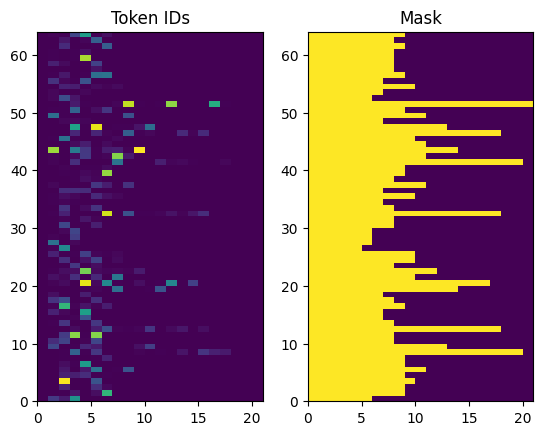

In [32]:
plt.subplot(1,2,1)
plt.pcolormesh(examples_token.to_tensor())
plt.title('Token IDs')

plt.subplot(1,2,2)
plt.pcolormesh(examples_token.to_tensor()!=0)
plt.title("Mask")

In [49]:
for context_x,target_x in train_raw.take(1):
  print(target_text_processor(target_x)[:3,:-1])
  print()
  print(target_text_processor(target_x)[:3,1:])

<tf.RaggedTensor [[2, 13, 12, 884, 94, 21, 77, 155, 189, 4], [2, 26, 63, 2105, 4],
 [2, 9, 107, 23, 74, 225, 222, 16, 4]]>

<tf.RaggedTensor [[13, 12, 884, 94, 21, 77, 155, 189, 4, 3], [26, 63, 2105, 4, 3],
 [9, 107, 23, 74, 225, 222, 16, 4, 3]]>


# Process the dataset

Convert the dataset strings to zero padded tensor IDsand shifted the input and output target by one step

In [50]:
def process_dataset(context,target):
  context=context_text_processsor(context).to_tensor()
  target=target_text_processor(target)
  target_in=target[:,:-1].to_tensor()
  target_out=target[:,1:].to_tensor()

  return (context,target_in),target_out

train_ds=train_raw.map(process_dataset,tf.data.AUTOTUNE)
val_ds=val_raw.map(process_dataset,tf.data.AUTOTUNE)

First sequence of each from the first batch

In [51]:
for (ex_context_tokens,ex_target_in),ex_target_out in train_ds.take(1):
  print(ex_context_tokens[0,:10].numpy())
  print()
  print(ex_target_in[0,:10].numpy())
  print(ex_target_out[0,:10].numpy())

[   2   26 1311    6   34 3327   17    1    8   16]

[   2 2555 1306 3715    7   10 1819 1310    4    0]
[2555 1306 3715    7   10 1819 1310    4    3    0]


The Encoder And Decoder

# The Encoder

In [52]:
Units=256

In [73]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)


    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)


    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [74]:
# Encode the input sequence.
encoder = Encoder(context_text_processsor, Units)
ex_context = encoder(ex_context_tokens)

print(f'Context tokens, shape (batch, s): {ex_context_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')


Context tokens, shape (batch, s): (64, 17)
Encoder output, shape (batch, s, units): (64, 17, 256)


# Attention Layer

In [77]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,units,**kwargs):
    super().__init__()
    self.mha=tf.keras.layers.MultiHeadAttention(key_dim=units,num_heads=1,**kwargs)
    self.layernorm=tf.keras.layers.LayerNormalization()
    self.add=tf.keras.layers.Add()

  def call(self,x,context):

    attn_output,attn_scores=self.mha(query=x,
                                     value=context,
                                     return_attention_scores=True)

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    self.last_attention_weights = attn_scores

    x=self.add([x,attn_output])
    x=self.layernorm(x)

    return x

In [78]:

attention_layer = CrossAttention(Units)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=Units, mask_zero=True)
ex_tar_embed = embed(ex_target_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')


Context sequence, shape (batch, s, units): (64, 17, 256)
Target sequence, shape (batch, t, units): (64, 16, 256)
Attention result, shape (batch, t, units): (64, 16, 256)
Attention weights, shape (batch, t, s):    (64, 16, 17)


Attention Wights will sum to 1 over context sequence ,at each target sequence

In [80]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)


array([1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 0.9999999 , 1.        , 1.        , 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994], dtype=float32)

# The Decoder

In [90]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls,fun):
    setattr(cls,fun.__name__,fun)
    return fun

  def __init__(self,units,text_processor):
    super(Decoder,self).__init__()

    self.processor=text_processor
    self.units=units

    self.word_to_id=tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(),
                                                 mask_token='',oov_token='[UNK]')

    self.id_to_word=tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(),
                                                 mask_token='',oov_token='[UNK]',invert=True)

    self.start_token=self.word_to_id('[START]')
    self.end_token=self.word_to_id('[END]')

    self.vocab_size=text_processor.vocabulary_size()

    # Embedding layer that convert token Ids to vector

    self.embedding=tf.keras.layers.Embedding(self.vocab_size,units,mask_zero=True)

    # Attention Layer
    self.attention=CrossAttention(Units)

    # RNN layer
    self.rnn=tf.keras.layers.GRU(units,recurrent_initializer='glorot_uniform',
                                 return_state=True,return_sequences=True)

    # output_layer

    self.output_layer=tf.keras.layers.Dense(self.vocab_size)


Training Method

In [91]:
@Decoder.add_method
def call(self,context,x,state=None,return_state=False):

  # targent_in passing through Embedding Layer
  x=self.embedding(x)

  # Passing through RNN layer
  x,state=self.rnn(x,initial_state=state)

  # use the RNN output as a query and context as value and pass it to Attention layer
  x=self.attention(x,context)

  self.last_attention_weights=self.attention.last_attention_weights

  logits=self.output_layer(x)

  if return_state:
    return logits,state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [92]:
decoder=Decoder(Units,target_text_processor)

In training you'll use the decoder like this:

Given the context and target tokens, for each target token it predicts the next target token.

In [93]:
logits = decoder(ex_context, ex_target_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_target_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')


encoder output shape: (batch, s, units) (64, 17, 256)
input target tokens shape: (batch, t) (64, 16)
logits shape shape: (batch, target_vocabulary_size) (64, 16, 5000)


Inference

In [94]:
@Decoder.add_method
def get_initial_state(self,context):
  batch_size=tf.shape(context)[0]
  start_tokens=tf.fill([batch_size,1],self.start_token)
  done=tf.zeros([batch_size,1],dtype=tf.bool)
  embedded=self.embedding(start_tokens)

  return start_tokens,done,self.rnn.get_initial_state(embedded)

In [101]:
@Decoder.add_method
def id_to_strings(self,tokens):
  word=self.id_to_word(tokens)
  result=tf.strings.reduce_join(word,axis=1,separator=" ")
  result=tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result=tf.strings.regex_replace(result,' *\[END\] *$','')
  return result

In [96]:
@Decoder.add_method
def get_next_token(self,context,next_token,done,state,temperature=0.0):
  logits,state=self(context,next_token,state=state,return_state=True)

  if temperature==0.0:
    next_token=tf.argmax(logits,axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  done=done | (next_token==self.end_token)

  next_token=tf.where(done,tf.constant(0,dtype=tf.int64),next_token)

  return next_token,done,state




With those extra functions, you can write a generation loop:

In [102]:
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for _ in range(10):
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.id_to_strings(tokens)
result[:3].numpy()



array([b'didnt customs support sucking bandage christians hong supporters chose goats',
       b'wings director wondering meet leftovers cost graduated broken nose announced',
       b'books equipment happens meters model bedroom come argument urged painted'],
      dtype=object)

# THE MODEL

In [103]:
class Translator(tf.keras.models.Model):
  @classmethod
  def add_method(cls,fun):
    setattr(cls,fun.__name__,fun)
    return fun

  def __init__(self,units,context_text_processor,target_text_processor):
    super().__init__()

    encoder=Encoder(context_text_processor,units)
    decoder=Decoder(units,target_text_processor)

    self.encoder=encoder
    self.decoder=decoder

  def call(self,inputs):
    context,x=inputs

    context=self.encoder(context)
    logits=self.decoder(context,x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During Training model will be like this

In [105]:
model = Translator(Units, context_text_processsor, target_text_processor)

logits = model((ex_context_tokens, ex_target_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tokens.shape}')
print(f'Target tokens, shape: (batch, t) {ex_target_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')


Context tokens, shape: (batch, s, units) (64, 17)
Target tokens, shape: (batch, t) (64, 16)
logits, shape: (batch, t, target_vocabulary_size) (64, 16, 5000)


# TRAIN

In [106]:
def masked_loss(y_true,y_pred):
  loss_fun=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')
  loss=loss_fun(y_true,y_pred)


  # mask off padded 0
  mask=tf.cast(y_true!=0,loss.dtype)
  loss *=mask

  return loss

In [107]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)


Compile the model

In [109]:
model.compile(loss=masked_loss,optimizer="adam",metrics=[masked_acc,masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [111]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}


{'expected_loss': 8.517193, 'expected_acc': 0.0002}

That should roughly match the values returned by running a few steps of evaluation:

In [112]:
model.evaluate(val_ds, steps=20, return_dict=True)


20/20 [==============================] - 16s 263ms/step - loss: 4.4088 - masked_acc: 2.8640e-04 - masked_loss: 4.3341


{'loss': 4.408815383911133,
 'masked_acc': 0.0002863987465389073,
 'masked_loss': 4.3340582847595215}

In [113]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])


Epoch 1/100
100/100 [==============================] - 99s 819ms/step - loss: 2.5492 - masked_acc: 0.2508 - masked_loss: 2.4872 - val_loss: 2.0836 - val_masked_acc: 0.3550 - val_masked_loss: 2.0565
Epoch 2/100
100/100 [==============================] - 91s 914ms/step - loss: 1.8446 - masked_acc: 0.3941 - masked_loss: 1.7826 - val_loss: 1.6995 - val_masked_acc: 0.4321 - val_masked_loss: 1.6524
Epoch 3/100
100/100 [==============================] - 82s 819ms/step - loss: 1.5422 - masked_acc: 0.4746 - masked_loss: 1.5030 - val_loss: 1.5179 - val_masked_acc: 0.5088 - val_masked_loss: 1.4922
Epoch 4/100
100/100 [==============================] - 87s 872ms/step - loss: 1.3165 - masked_acc: 0.5344 - masked_loss: 1.2879 - val_loss: 1.2321 - val_masked_acc: 0.5401 - val_masked_loss: 1.1847
Epoch 5/100
100/100 [==============================] - 91s 908ms/step - loss: 1.2302 - masked_acc: 0.5724 - masked_loss: 1.1953 - val_loss: 1.0466 - val_masked_acc: 0.5873 - val_masked_loss: 1.0081
Epoch 6/10

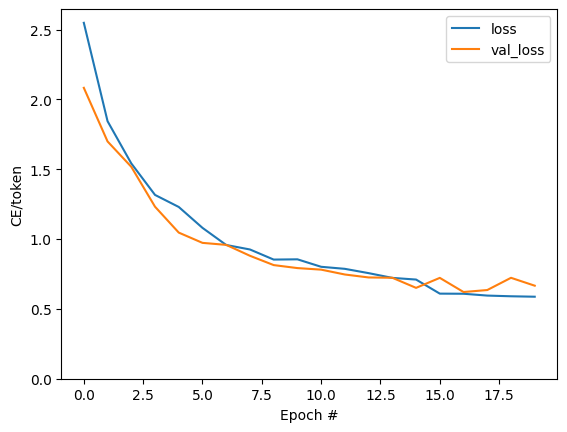

In [114]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()


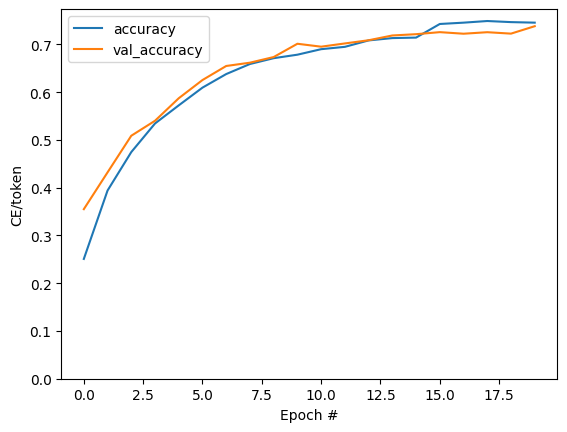

In [115]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()


Translate the input sentences`

In [118]:
@Translator.add_method
def translate(self,texts,max_length=50,temperature=0.0):

  context=self.encoder.convert_input(texts)
  batch_size=tf.shape(texts)[0]

  tokens=[]
  attention_weights=[]
  next_token,done,state=self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate next  token
    next_token,done,state=self.decoder.get_next_token(context,next_token,done,state,temperature)

    # collect the generated token
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  tokens=tf.concat(tokens,axis=-1)
  self.last_attention_weights=tf.concat(attention_weights,axis=1)

  result=self.decoder.id_to_strings(tokens)
  return result


In [121]:
result=model.translate(['¿Todavía está en casa?'])
result[0].numpy().decode()

'are you still at home ? '

In [136]:
@Translator.add_method
def plot_attention(self,text,**kwargs):
  result=self.translate([text],**kwargs)
  output=result[0].numpy().decode()

  attention=self.last_attention_weights[0]

  context=preprocessing(text)
  context=context.numpy().decode().split()

  output=preprocessing(output)
  output=output.numpy().decode().split()[1:]

  fig=plt.figure(figsize=(10,10))
  ax=fig.add_subplot(1,1,1)

  ax.matshow(attention,cmap='viridis',vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels(['']+context,fontdict=fontdict,rotation=90)
  ax.set_yticklabels(['']+output,fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')


<ipython-input-136-d8ffec2f570d>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+context,fontdict=fontdict,rotation=90)
<ipython-input-136-d8ffec2f570d>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+output,fontdict=fontdict)


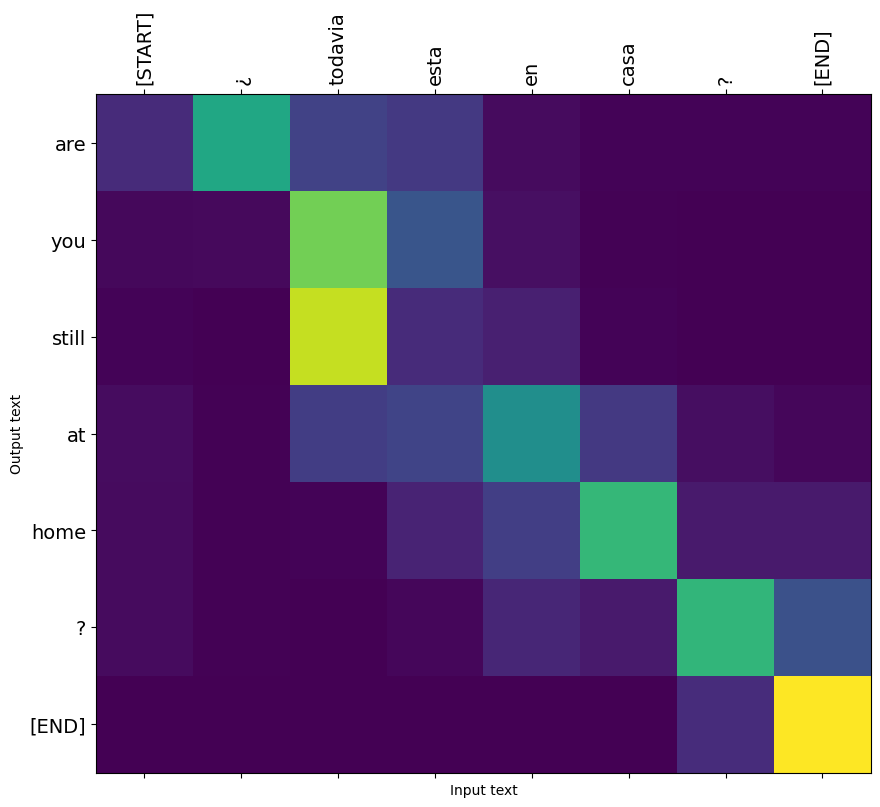

In [137]:
model.plot_attention('¿Todavía está en casa?')

<ipython-input-136-d8ffec2f570d>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+context,fontdict=fontdict,rotation=90)
<ipython-input-136-d8ffec2f570d>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+output,fontdict=fontdict)


CPU times: user 334 ms, sys: 0 ns, total: 334 ms
Wall time: 337 ms


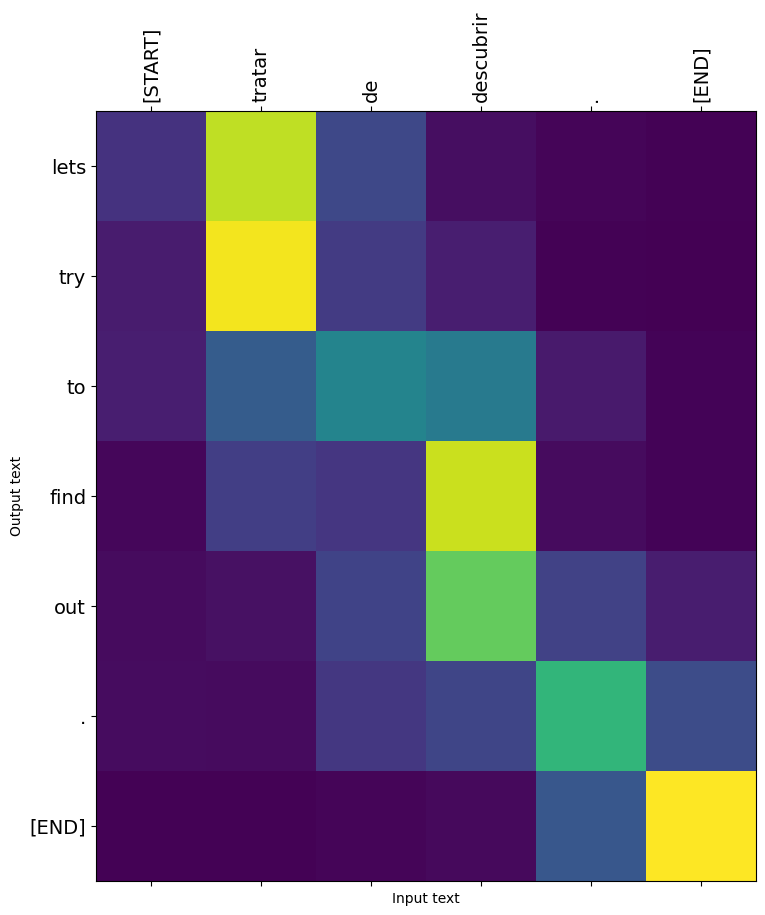

In [138]:
%%time
# Try to find out.'
model.plot_attention('Tratar de descubrir.')


Longest text

In [139]:
long_text=context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))


Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


<ipython-input-136-d8ffec2f570d>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+context,fontdict=fontdict,rotation=90)
<ipython-input-136-d8ffec2f570d>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+output,fontdict=fontdict)


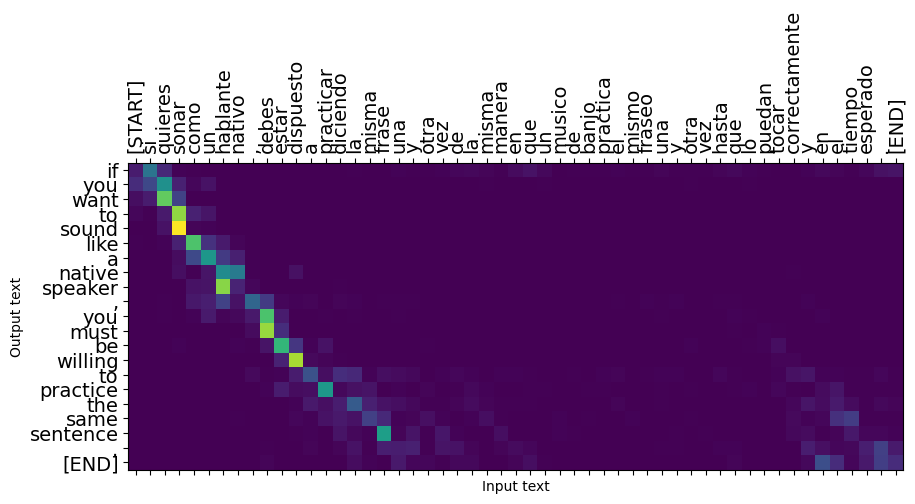

In [140]:
model.plot_attention(long_text)

Translating the multiple sentences

In [141]:
inputs=[
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"

]

In [144]:
for input in inputs:
  print(model.translate([input])[0].numpy().decode())

print()

its very cold here . 
this is my life . 
his room is a [UNK] . 

